In [1]:
from keras.layers import LSTM, Bidirectional, Embedding, Input, Flatten, Dense, BatchNormalization, Dropout, Conv1D, Concatenate, MaxPool1D, AveragePooling1D, GlobalAveragePooling1D, GlobalMaxPool1D, SpatialDropout1D, TimeDistributed, Lambda 

Using TensorFlow backend.


In [2]:
from keras.layers import Add

In [3]:
from keras.optimizers import Adam

In [4]:
import keras
import tensorflow as tf
import keras.backend as K
from keras.models import Model

In [5]:
from keras.preprocessing.sequence import pad_sequences

In [6]:
from keras.utils import plot_model

In [7]:
import numpy as np
import math

In [8]:
import joblib
from sklearn.metrics import roc_auc_score

In [9]:
def pepare_train_test(file, tokenizer,sample=None):
    import pandas as pd
    from sklearn.model_selection import train_test_split
    train_df = pd.read_csv(file)
    train_binary = np.zeros((len(train_df),))
    train_binary[train_df['target']>0.5] = 1
    train_df['target_binary'] = train_binary
    train, test  = train_test_split(train_df, test_size=0.2, random_state=42,stratify=train_df['target_binary'])
    if sample:
        train = train.sample(sample)
        test = test.sample(int(sample/10))
    return tokenizer.texts_to_sequences(train['comment_text'].values.astype(str).tolist()), train['target_binary'].values, tokenizer.texts_to_sequences(test['comment_text'].values.astype(str).tolist()), test['target_binary'].values


In [10]:
# import pandas as pd
# from sklearn.model_selection import train_test_split
# train_df = pd.read_csv('train_clean.csv')
# train_binary = np.zeros((len(train_df),))
# train_binary[train_df['target']>0.5] = 1
# train_df['target_binary'] = train_binary
# train, test  = train_test_split(train_df, test_size=0.2, random_state=42,stratify=train_df['target_binary'])

In [11]:
# train['comment_text'].tolist()[:10]


In [12]:
embedding = joblib.load('./embedding')

In [13]:
tokenizer = joblib.load('./tokenizer')

In [14]:
trainx, trainy, testx, testy = pepare_train_test('train_clean.csv', tokenizer)

In [15]:
maxlen = 200

In [16]:
class RocAucEvaluation(keras.callbacks.Callback):
    def __init__(self, validation_data=(), interval=1):
        super(keras.callbacks.Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            y_orig_test = np.zeros(len(self.y_val))
            y_orig_test[self.y_val >= 0.5 ] = 1
            y_pred_scaled = np.zeros(y_pred.shape[0],)
            y_pred = y_pred.reshape(y_pred.shape[0],)
            y_pred_scaled[y_pred >= 0.5 ] = 1
            score = roc_auc_score(y_orig_test, y_pred_scaled)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))

In [17]:
from time import time
callbacks_list = [
    # This callback will interrupt training when we have stopped improving
    keras.callbacks.EarlyStopping(
        # This callback will monitor the validation accuracy of the model
        monitor='val_loss',
        # Training will be interrupted when the accuracy
        # has stopped improving for *more* than 1 epochs (i.e. 2 epochs)
        patience=3,
    ),
    # This callback will save the current weights after every epoch
    keras.callbacks.ModelCheckpoint(
        filepath='models/best_model_cnn_yk.h5',  # Path to the destination model file
        # The two arguments below mean that we will not overwrite the
        # model file unless `val_loss` has improved, which
        # allows us to keep the best model every seen during training.
        monitor='val_loss',
        save_best_only=True,
    ),
    keras.callbacks.TensorBoard(log_dir='./logs/{}'.format(time()), histogram_freq=0, batch_size=1024, update_freq='batch'),
    RocAucEvaluation(validation_data=(pad_sequences(testx,maxlen), testy), interval=1)

]

In [18]:
def get_cnn_model(embedding, maxlen):
    input = Input(shape=(maxlen,), name="input_sentence")
    x = Embedding(input_dim=embedding.shape[0], output_dim=embedding.shape[1], input_length=maxlen, weights=[embedding], trainable=False, mask_zero=False)(input)
    cnn_x1 = Conv1D(kernel_size=2, filters=128)(x)
    cnn_x2 = Conv1D(kernel_size=3,filters=128)(x)
    cnn_x3 = Conv1D(kernel_size=4,filters=128)(x)
    cnn_x4 = Conv1D(kernel_size=5,filters=128)(x)
    cnn_x1_mp = GlobalMaxPool1D()(cnn_x1)
    cnn_x2_mp = GlobalMaxPool1D()(cnn_x2)
    cnn_x3_mp = GlobalMaxPool1D()(cnn_x3)
    cnn_x4_mp = GlobalMaxPool1D()(cnn_x4)
    cnn_x1_avg = GlobalAveragePooling1D()(cnn_x1)
    cnn_x2_avg = GlobalAveragePooling1D()(cnn_x2)
    cnn_x3_avg = GlobalAveragePooling1D()(cnn_x3)
    cnn_x4_avg = GlobalAveragePooling1D()(cnn_x4)
    concat_layer = Concatenate()([cnn_x1_mp,cnn_x2_mp,cnn_x3_mp,cnn_x4_mp,cnn_x1_avg,cnn_x2_avg,cnn_x3_avg,cnn_x4_avg])
#     flatten_layer = Flatten()(concat_layer)
    concat_layer_drop = Dropout(0.2)(concat_layer)
    output_dense = Dense(128, activation='relu')(concat_layer_drop)
    output_dense = Dropout(0.2)(output_dense)
    output_dense = Dense(32, activation='relu')(output_dense)
    output_dense = Dropout(0.2)(output_dense)
    output = Dense(1, activation='sigmoid')(output_dense)
    return Model(input,output)

In [19]:
model = get_cnn_model(embedding,maxlen)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [20]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_sentence (InputLayer)     (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 200, 300)     30450300    input_sentence[0][0]             
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 199, 128)     76928       embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 198, 128)     115328      embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_3 (

In [21]:
plot_model(model,'cnn_yk_2.png')

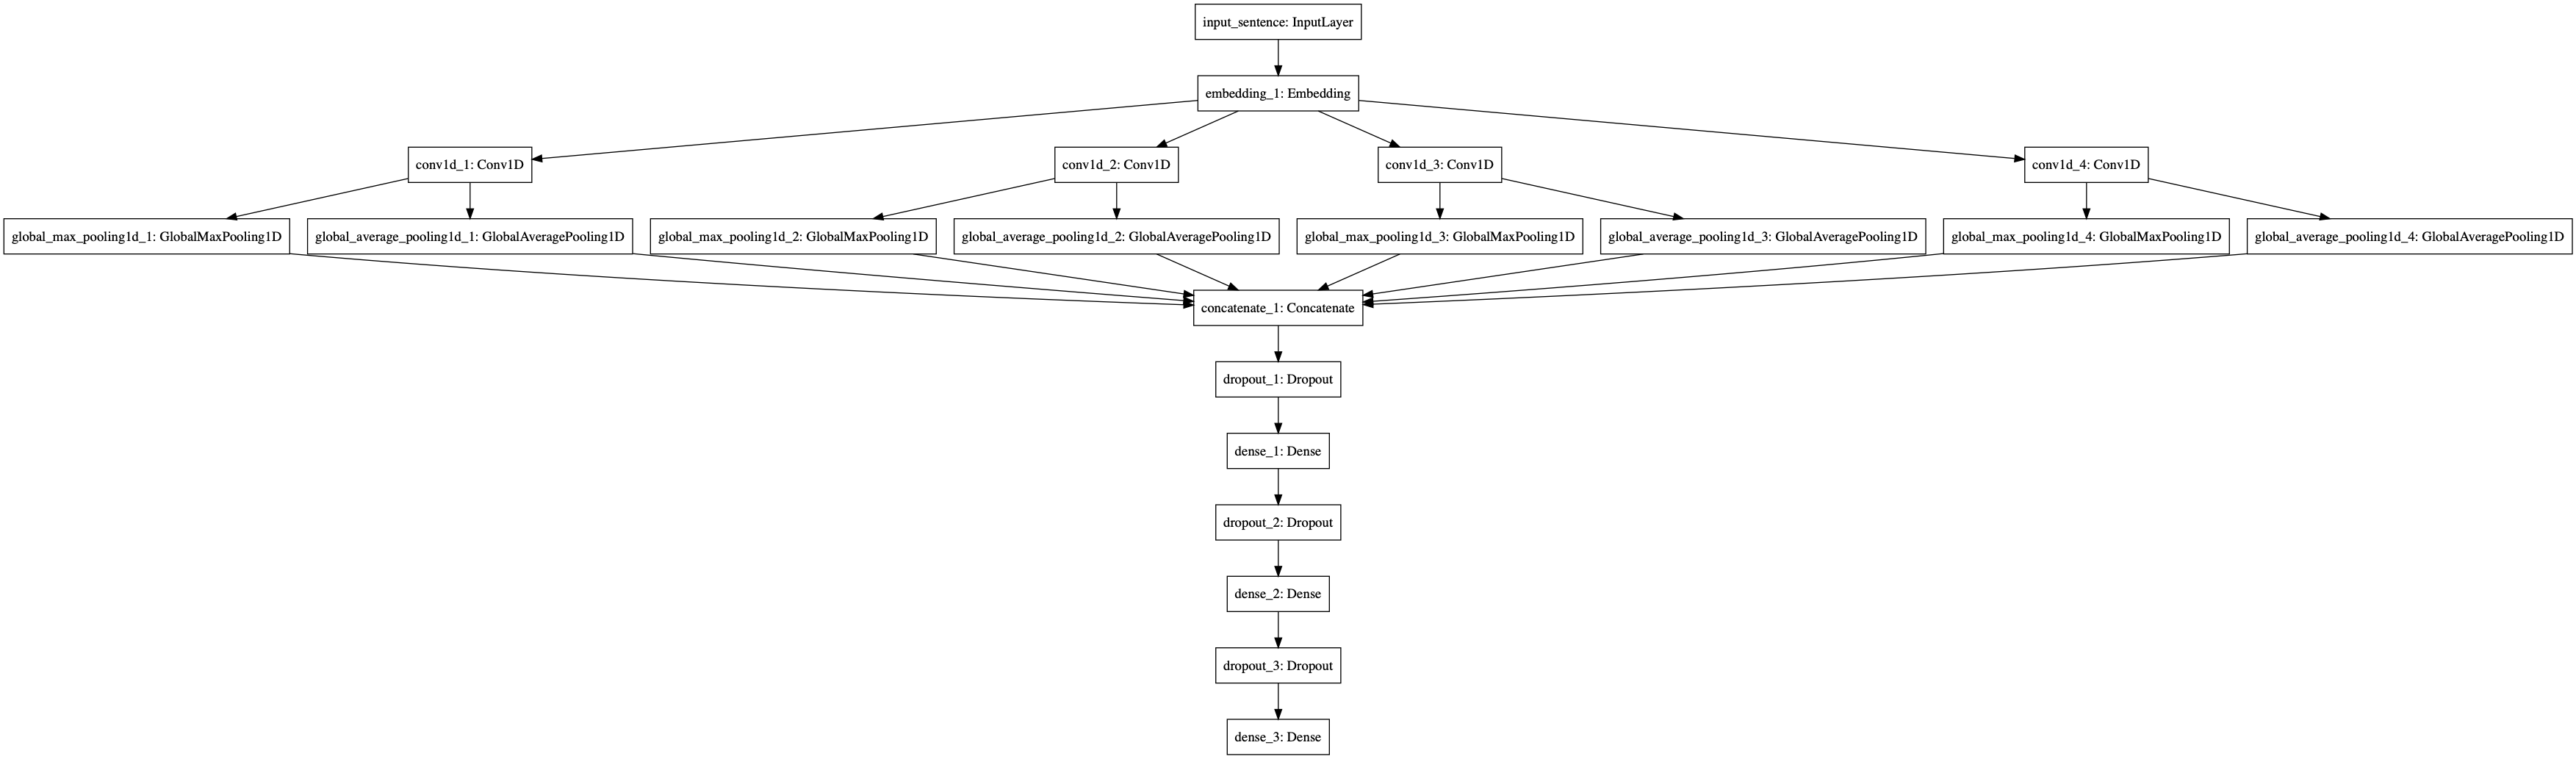

In [23]:
from IPython.display import Image
Image('cnn_yk_2.png')

In [26]:
model.compile(loss='binary_crossentropy', optimizer=Adam(clipnorm=0.1,lr=0.001, clipvalue=0.05, decay=0.1), metrics=['acc','mean_squared_error'])

In [ ]:
model.fit(pad_sequences(trainx,maxlen), trainy, validation_data=(pad_sequences(testx,maxlen), testy),epochs=10, batch_size=64, callbacks=callbacks_list)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 1443899 samples, validate on 360975 samples
Epoch 1/10
 822592/1443899 [================>.............] - ETA: 43:30 - loss: 0.1797 - acc: 0.9413 - mean_squared_error: 0.0484

In [144]:
# model.save('transformer_without_pe_epoch1.h5')